In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('Items Shipped by Item by Month.csv')

In [2]:
df.head()

,Date,Item,Item Description,Product Group,Parent Product Group,Quantity,Amount
0,2024-Sep,2151,Original 36in Griddle W/Hood,Griddles,Cooking Unit,168.0,42504.00
1,2024-Sep,5482SA,"36"" Griddle with hood cover - Saudi Arabia",Covers/Bags - GRD,Accessory,297.0,6073.65
2,2024-Sep,5483SA,"28"" GRIDDLE COVER - Saudi Arabia",Covers/Bags - GRD,Accessory,297.0,5702.40
3,2024-Sep,2370,28in Omnivore Original Series Griddle,Griddles,Cooking Unit,2668.0,276184.42
4,2024-Sep,2370,28in Omnivore Original Series Griddle,Griddles,Cooking Unit,3654.0,378252.58


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383972 entries, 0 to 383971
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Date                  383972 non-null  object 
 1   Item                  383972 non-null  object 
 2   Item Description      382044 non-null  object 
 3   Product Group         376304 non-null  object 
 4   Parent Product Group  383972 non-null  object 
 5   Quantity              383001 non-null  float64
 6   Amount                383972 non-null  float64
dtypes: float64(2), object(5)
memory usage: 20.5+ MB


In [4]:
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
item = '4114'

df = df.groupby(['Date','Item'])['Quantity'].sum().reset_index().sort_values(by='Date', ascending=True)

df_item = df[df['Item'] == item]

df_item = df_item.resample('M', on='Date').sum().reset_index()

C:\Users\clata\AppData\Local\Temp\ipykernel_36888\3594318846.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_item = df_item.resample('M', on='Date').sum().reset_index()


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56556 entries, 0 to 56555
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      56556 non-null  datetime64[ns]
 1   Item      56556 non-null  object        
 2   Quantity  56556 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.7+ MB


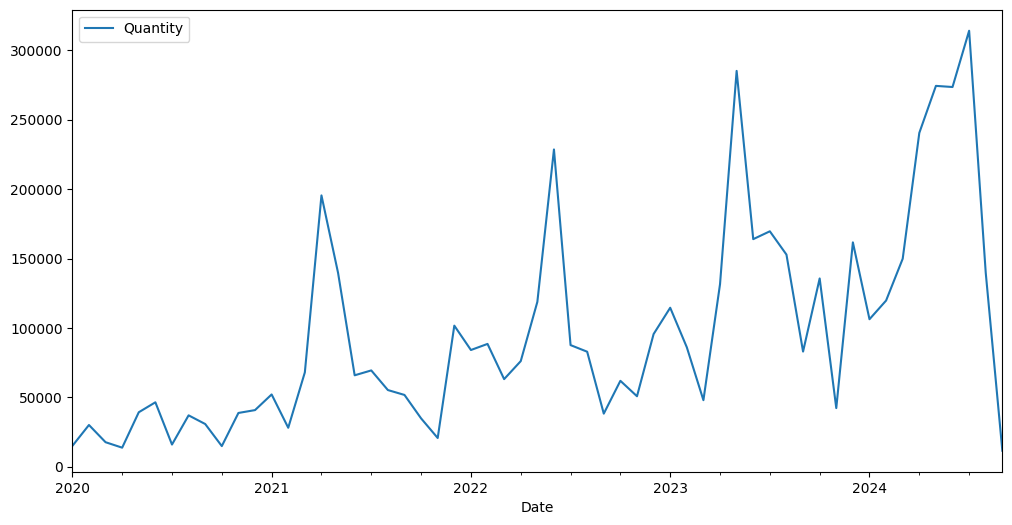

In [7]:
# Plot the time series data
df_item.plot(x='Date', y='Quantity', figsize=(12,6))
unchanged_df = df_item.copy()

## Data Transformation

### Box Cox Transformation

In [8]:
from scipy.stats import boxcox

        Date  Quantity  boxcox_units
0 2020-01-31   14981.0     20.615664
1 2020-02-29   30057.0     23.500163
2 2020-03-31   17657.0     21.270890
3 2020-04-30   13723.0     20.272220
4 2020-05-31   39238.0     24.682421
The optimal lambda for Box-Cox transformation is: 0.14262173021138388


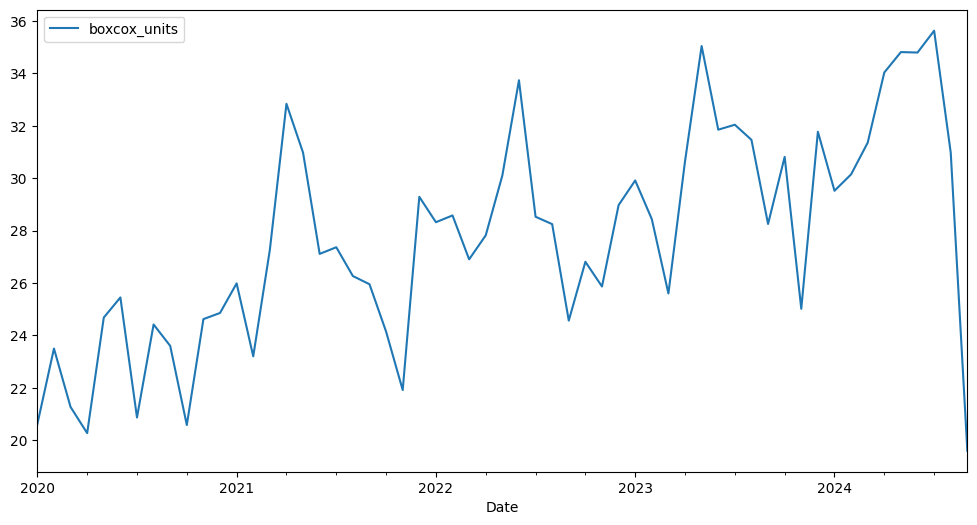

In [9]:

# Apply Box-Cox transformation to find the optimal lambda
df_item['boxcox_units'] , optimal_lambda = boxcox(df_item.Quantity)
print(df_item.head())
box_cox_df = df_item.copy()

# Plot the transformed data with optimal lambda
df_item.plot(x='Date', y='boxcox_units', figsize=(12,6))

# Print the optimal lambda
print(f'The optimal lambda for Box-Cox transformation is: {optimal_lambda}')

## ACF and PACF

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

c:\Users\clata\anaconda3\envs\myenv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


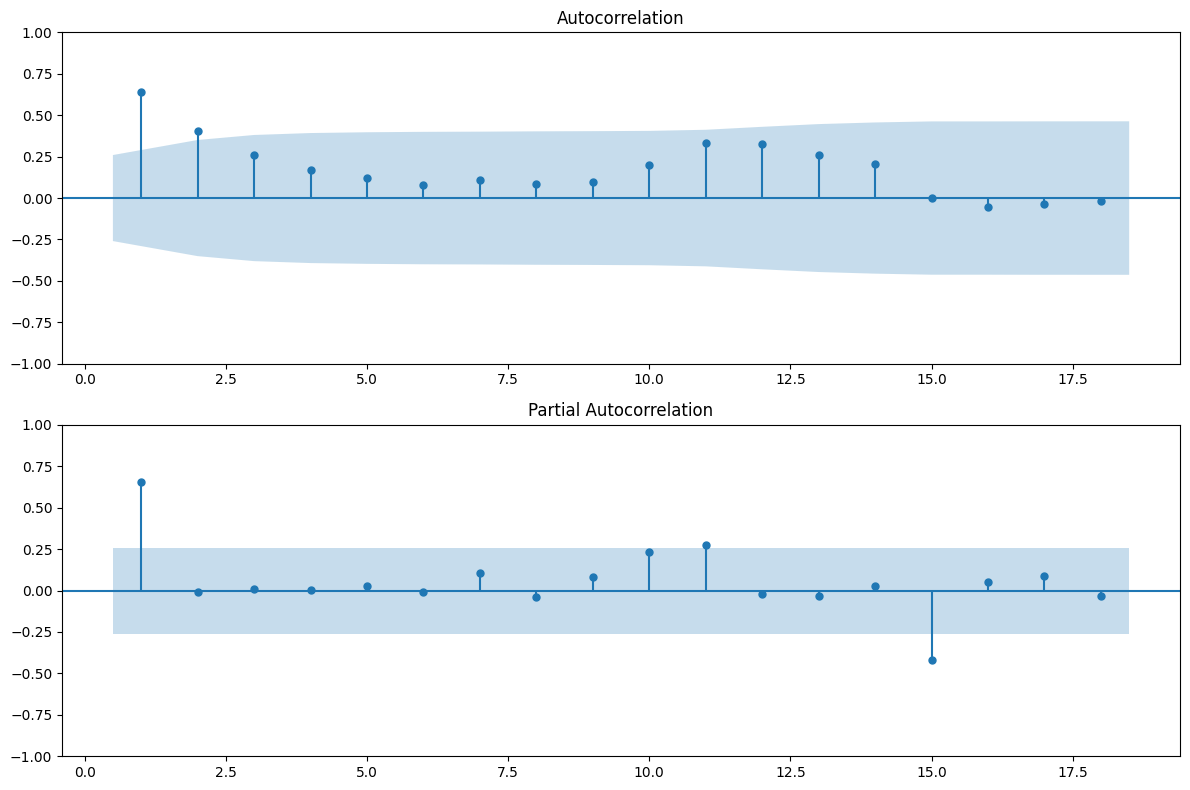

In [11]:
# Plot ACF and PACF for the original airline passenger data
plt.figure(figsize=(12, 8))
plt.subplot(211)
plot_acf(df_item['Quantity'], ax=plt.gca(), zero=False)
plt.subplot(212)
plot_pacf(df_item['Quantity'], ax=plt.gca(), zero=False)
plt.tight_layout()
plt.show()

## Stationarity

In [12]:
from statsmodels.tsa.stattools import adfuller

In [13]:
# Function to perform ADF test
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string())
    if result[1] <= 0.05:
        print("=> The series is stationary.")
    else:
        print("=> The series is non-stationary.")

Augmented Dickey-Fuller Test: boxcox quantity- Differenced
ADF Test Statistic             -4.338150
p-value                         0.000381
# Lags Used                     9.000000
Number of Observations Used    46.000000
Critical Value (1%)            -3.581258
Critical Value (5%)            -2.926785
Critical Value (10%)           -2.601541
=> The series is stationary.


<Axes: xlabel='Date'>

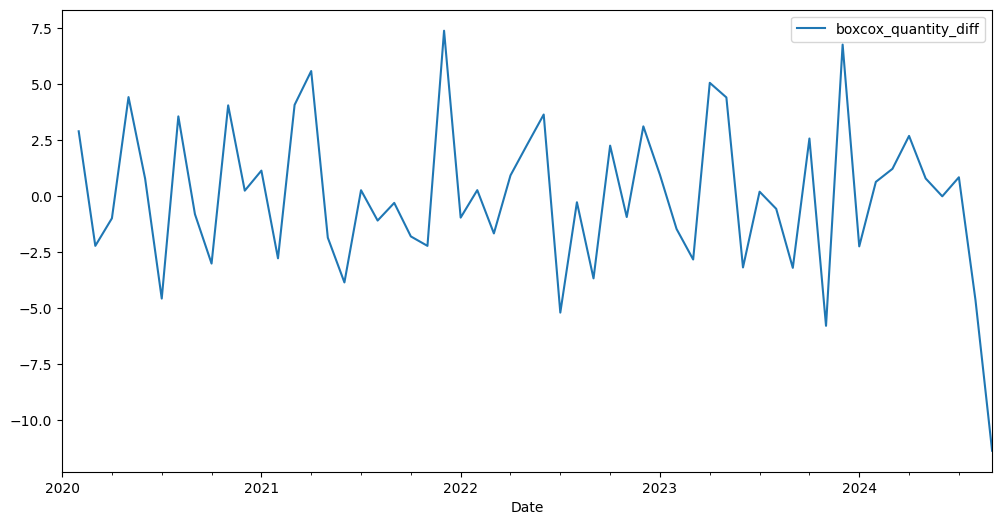

In [14]:
df_item['boxcox_quantity_diff'] = df_item['boxcox_units'].diff()

# Perform ADF test on differenced data
adf_test(df_item['boxcox_quantity_diff'].dropna(), title='boxcox quantity- Differenced')

# Plot the differenced data
df_item.plot(x='Date', y='boxcox_quantity_diff', figsize=(12,6))

## Benchmarking

#### Multi-Horizon Benchmark

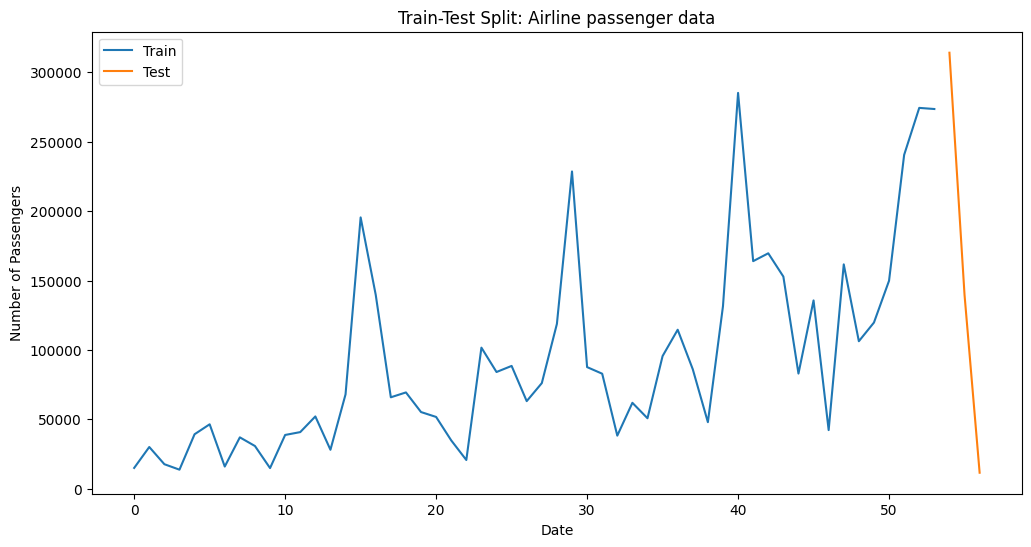

In [15]:
# Split the data
train = df_item[['Quantity']][:-3]
test = df_item[['Quantity']][-3:]

# Visualize the train and test data
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.title('Train-Test Split: Airline passenger data')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

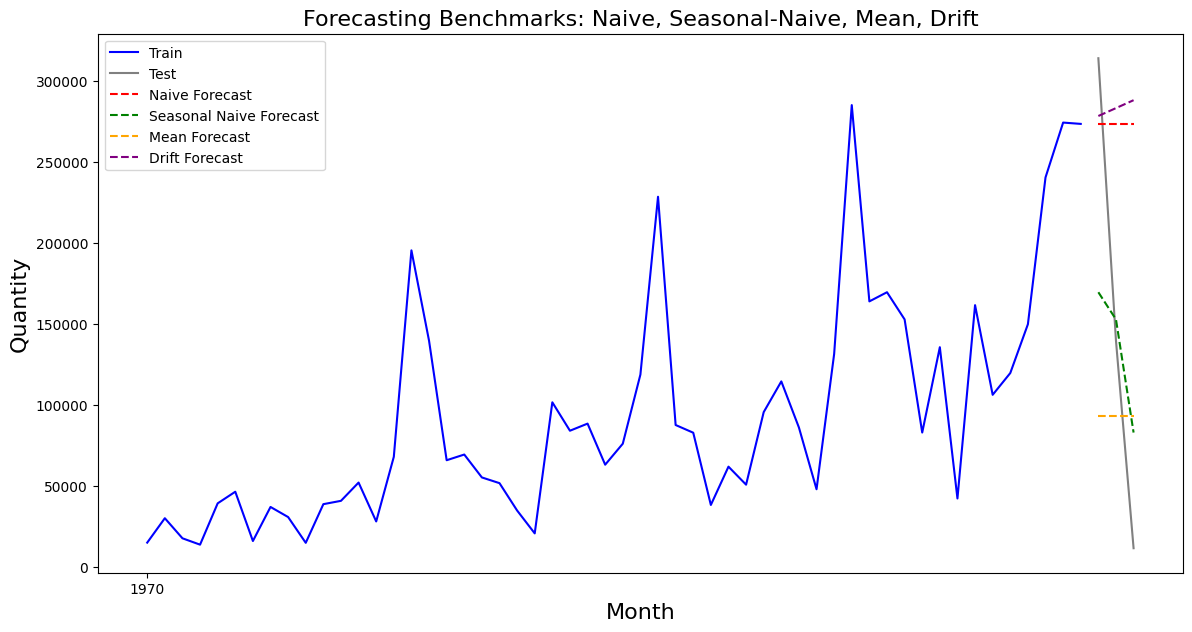

In [16]:
# Naive Forecast
# The naive forecaster simply uses the last observation from the training set
# as the forecast for all future observations.
y_hat_naive = test.copy()
y_hat_naive['naive'] = train.iloc[-1]['Quantity']

# Seasonal Naive Forecast:
# The seasonal naive forecaster uses the observation 
# from the same season of the previous cycle as the forecast.
season_length = 12
train_values_for_snaive = train['Quantity'].values[-season_length:]  # Last season's data
y_hat_snaive = test.copy()
y_hat_snaive['snaive'] = np.tile(train_values_for_snaive, len(test)//season_length+1)[:len(test)]

# Mean Forecast:
# The mean forecaster uses the mean of the training set as the forecast for all future observations.
y_hat_mean = test.copy()
y_hat_mean['mean'] = train['Quantity'].mean()

# Drift Forecast:
# The drift forecaster extrapolates a line between the first and last observations
# in the training set.
y_hat_drift = test.copy()
num_periods = len(train) - 1
drift = (train['Quantity'].iloc[-1] - train['Quantity'].iloc[0]) / num_periods
y_hat_drift['drift'] = [train['Quantity'].iloc[-1] + (i+1) * drift for i in range(len(test))]


# Ensure index types are correct
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
y_hat_naive.index = pd.to_datetime(y_hat_naive.index)
y_hat_snaive.index = pd.to_datetime(y_hat_snaive.index)
y_hat_mean.index = pd.to_datetime(y_hat_mean.index)
y_hat_drift.index = pd.to_datetime(y_hat_drift.index)

# Visualization
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Quantity'], label='Train', color='blue')
plt.plot(test.index, test['Quantity'], label='Test', color='grey')
plt.plot(y_hat_naive.index, y_hat_naive['naive'], label='Naive Forecast', color='red', linestyle='--')
plt.plot(y_hat_snaive.index, y_hat_snaive['snaive'], label='Seasonal Naive Forecast', color='green', linestyle='--')
plt.plot(y_hat_mean.index, y_hat_mean['mean'], label='Mean Forecast', color='orange', linestyle='--')
plt.plot(y_hat_drift.index, y_hat_drift['drift'], label='Drift Forecast', color='purple', linestyle='--')

plt.title('Forecasting Benchmarks: Naive, Seasonal-Naive, Mean, Drift', fontsize=16)
plt.xlabel('Month',fontsize=16)
plt.ylabel('Quantity',fontsize=16)
plt.legend(loc='upper left')
plt.show()

#### One Step ahead benchmark

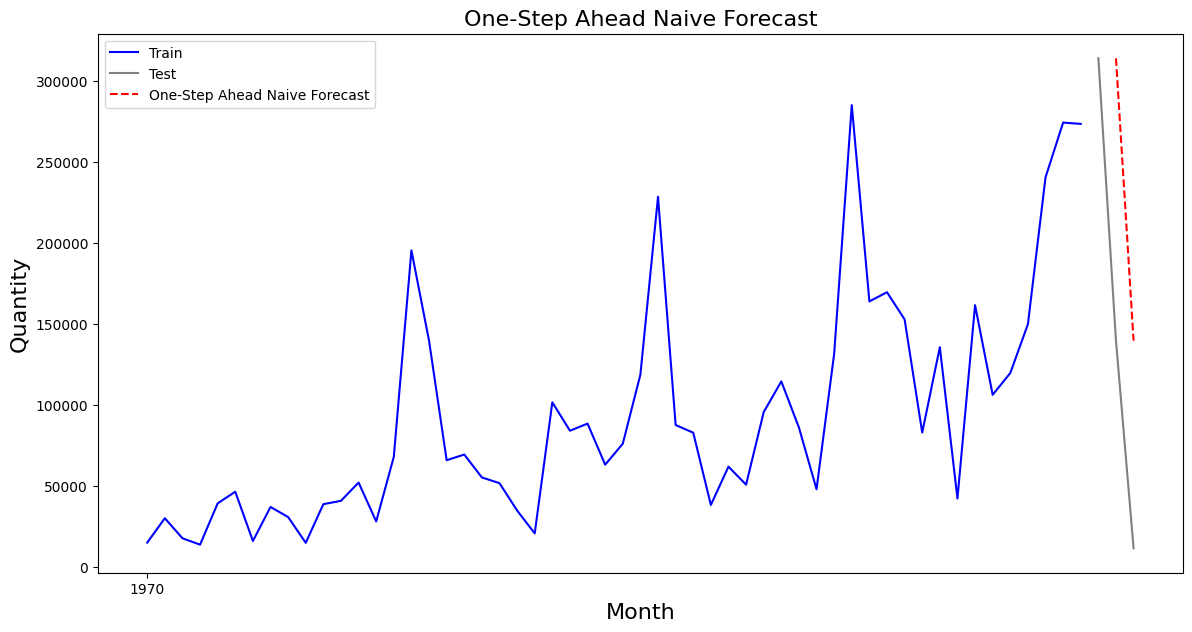

In [17]:
# Correcting the Naive Forecast for a true one-step ahead visualization
y_hat_naive_corrected = df_item.copy()
y_hat_naive_corrected['naive_one_step'] = df_item['Quantity'].shift(1)

# Adjusting visualization to focus on one-step ahead naive forecast in the test set
plt.figure(figsize=(14, 7))

# Original data (Train and Test)
plt.plot(train.index, train['Quantity'], label='Train', color='blue')
plt.plot(test.index, test['Quantity'], label='Test', color='grey')

# One-step ahead naive forecast (Test set only)
# Shifting the test data one step for the naive forecast
test_shifted_for_naive = test['Quantity'].shift(1)
plt.plot(test.index, test_shifted_for_naive, label='One-Step Ahead Naive Forecast', color='red', linestyle='--')

plt.title('One-Step Ahead Naive Forecast', fontsize=16)
plt.xlabel('Month', fontsize=16)
plt.ylabel('Quantity',fontsize=16)
plt.legend(loc='upper left')
plt.show()

## Pycaret Forecast

In [18]:
from pycaret.time_series import *

In [19]:
df_item.head()

,Date,Quantity,boxcox_units,boxcox_quantity_diff
0,2020-01-31,14981.0,20.615664,NaN
1,2020-02-29,30057.0,23.500163,2.884499
2,2020-03-31,17657.0,21.270890,-2.229273
3,2020-04-30,13723.0,20.272220,-0.998670
4,2020-05-31,39238.0,24.682421,4.410202


In [20]:
df_item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  57 non-null     datetime64[ns]
 1   Quantity              57 non-null     float64       
 2   boxcox_units          57 non-null     float64       
 3   boxcox_quantity_diff  56 non-null     float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.9 KB


In [21]:
df_item = df_item.drop(columns = ['Quantity','boxcox_units'])
df_item = df_item.set_index('Date')
df_item.tail()

,boxcox_quantity_diff
Date,
2024-05-31,0.778504
2024-06-30,-0.017721
2024-07-31,0.832448
2024-08-31,-4.653885
2024-09-30,-11.373002


In [22]:
exp = TSForecastingExperiment()
exp.setup(data = df_item, target='boxcox_quantity_diff', numeric_imputation_target='mean', fh=3)

,Description,Value
0,session_id,3746
1,Target,boxcox_quantity_diff
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(57, 1)"
5,Transformed data shape,"(57, 1)"
6,Transformed train set shape,"(54, 1)"
7,Transformed test set shape,"(3, 1)"
8,Rows with missing values,1.8%
9,Fold Generator,ExpandingWindowSplitter


In [23]:
exp.check_stats()

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,57.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,-0.018112
3,Summary,Statistics,Transformed,Median,,-0.017721
4,Summary,Statistics,Transformed,Standard Deviation,,3.384438
5,Summary,Statistics,Transformed,Variance,,11.454419
6,Summary,Statistics,Transformed,Kurtosis,,1.223131
7,Summary,Statistics,Transformed,Skewness,,-0.356189
8,Summary,Statistics,Transformed,# Distinct Values,,57.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",23.311425


#### Comparing Models

In [24]:
best = exp.compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.5610,0.5435,2.2360,2.6391,9.5088,1.2511,-2.0842,0.0667
arima,ARIMA,0.5616,0.5366,2.1574,2.5150,1.8854,1.3563,-0.1012,0.8200
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.5742,0.5529,2.2051,2.5940,0.8979,1.4203,-0.2271,0.1700
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.5742,0.5529,2.2051,2.5940,0.8979,1.4203,-0.2271,0.0533
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.5743,0.5529,2.2054,2.5939,0.8991,1.4206,-0.2267,0.1667
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.5792,0.5641,2.2248,2.6498,1.0901,1.3551,-0.3232,0.0567
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.5911,0.5567,2.2712,2.6110,1.0400,1.4972,-0.2075,0.1733
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.5969,0.5597,2.2931,2.6249,1.0355,1.5212,-0.2164,0.1733
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.6061,0.5632,2.3306,2.6422,1.1295,1.5667,-0.2117,0.1733
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.6061,0.5632,2.3306,2.6422,1.1295,1.5667,-0.2117,0.1700


In [26]:
tuned = exp.tune_model(best)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2023-09,1.2270,1.0840,4.6094,4.9329,0.9076,1.6676,0.1064
1,2023-12,0.2887,0.3228,1.1793,1.6120,0.6676,1.0210,-0.1352
2,2024-03,0.2606,0.2816,1.0656,1.4143,7.2334,1.4781,-0.5636
Mean,NaT,0.5921,0.5628,2.2848,2.6531,2.9362,1.3889,-0.1975
SD,NaT,0.4491,0.3690,1.6444,1.6141,3.0401,0.2714,0.2771


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.5s finished


#### Finalizing Model

In [27]:
final = exp.finalize_model(tuned)

In [28]:
exp.plot_model(final, plot='forecast', data_kwargs={'fh':3})

In [29]:

unseen_predictions = exp.predict_model(final, fh=3)
unseen_predictions

,y_pred
2024-10,6.1334
2024-11,-1.7651
2024-12,0.6556


#### Reversing Transformation

In [30]:
from scipy.special import inv_boxcox


last_original_value = box_cox_df['boxcox_units'].iloc[-1]
last_original_value

19.601367473541895

In [31]:
# Reverse differencing (undo stationarity)
reversed_diff_predictions = unseen_predictions.cumsum() + last_original_value
reversed_diff_predictions


,y_pred
2024-10,25.734767
2024-11,23.969667
2024-12,24.625267


In [32]:
# Example lambda value for Box-Cox transformation
boxcox_lambda = optimal_lambda

# Reverse Box-Cox transformation
original_scale_predictions = inv_boxcox(reversed_diff_predictions, boxcox_lambda)
original_scale_predictions

,y_pred
2024-10,49336.847978
2024-11,33453.800849
2024-12,38744.556740


In [33]:
unchanged_df.index = unchanged_df['Date']
unchanged_df = unchanged_df.drop(columns = ['Date'])
unchanged_df.tail()

,Quantity
Date,
2024-05-31,274359.0
2024-06-30,273545.0
2024-07-31,314098.0
2024-08-31,139681.0
2024-09-30,11525.0


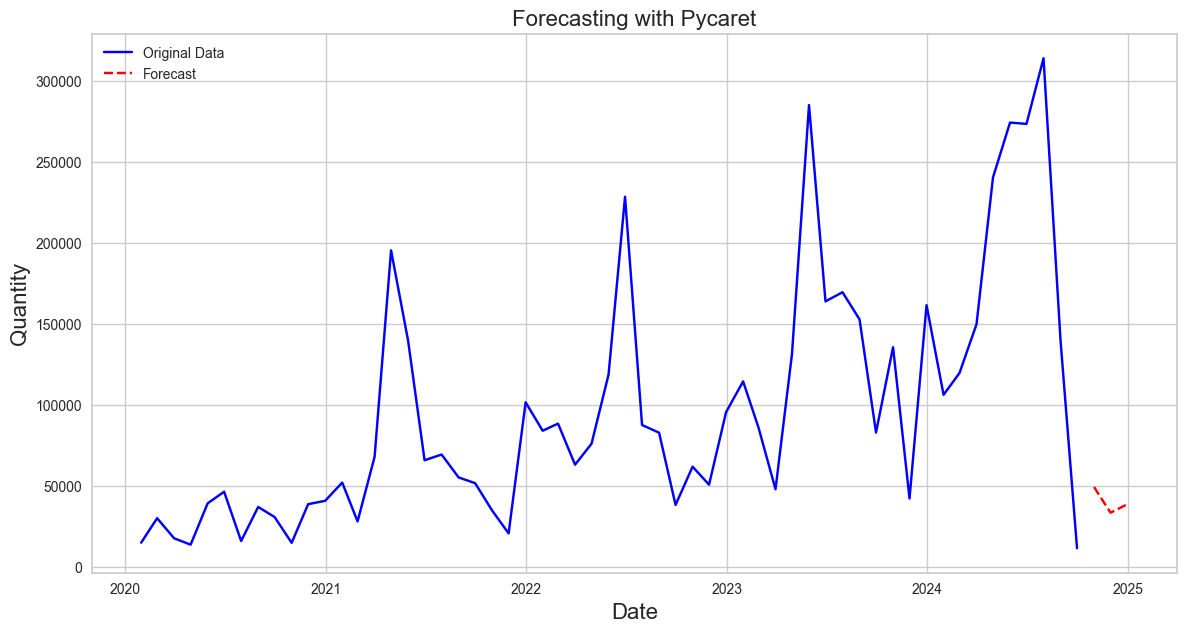

In [34]:
# plot original data and forecast
plt.figure(figsize=(14, 7))
plt.plot(unchanged_df.index, unchanged_df['Quantity'], label='Original Data', color='blue')
plt.plot(original_scale_predictions.index, original_scale_predictions, label='Forecast', color='red', linestyle='--')
plt.title('Forecasting with Pycaret', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Quantity', fontsize=16)
plt.legend(loc='upper left')
plt.show()